In [40]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("hola")
result

AIMessage(content='Hola. ¿Cómo estás?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 37, 'total_tokens': 45, 'completion_time': 0.01357722, 'prompt_time': 0.001659696, 'queue_time': 2.761152787, 'total_time': 0.015236916}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_90c2e79dab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--15cf8e97-169a-4894-a2ef-4212152e1200-0', usage_metadata={'input_tokens': 37, 'output_tokens': 8, 'total_tokens': 45})

In [41]:
##Tools 

def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args :
        a:first int
        b:second int
    """
    return a*b

def add(a:int,b:int)->int:
    """Add a and b

    Args :
        a:first int
        b:second int
    """
    return a+b

def divide(a:int,b:int)->int:
    """Divide a and b

    Args :
        a:first int
        b:second int
    """
    return a / b

tools=[add,multiply,divide]
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>]

In [42]:
##Integrate tools

llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001807D030830>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001807D032630>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b Args :\n    a:first int\n    b:second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b Args :\n    a:first int\n    b:second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a and b Args :\n    a:first int\n    b:second int', 'parameters': {'properties': {'a': {'type': 'int

In [ ]:
##Workfolw with langgraph

from IPython.display import Image ,display
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

sys_msg=SystemMessage(content="You are a helpful AI assitance taked with performing arithmatic on a set of values")

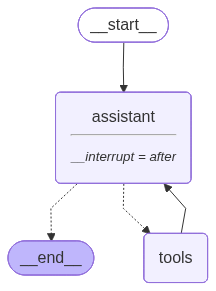

In [ ]:
def assistant(state:MessagesState):
    return{"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}


builder=StateGraph(MessagesState)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"assistant")

builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools","assistant")
memeory=MemorySaver()

graph=builder.compile(interrupt_after=["assistant"],checkpointer=memeory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [48]:
thread = {"configurable": {"thread_id": "123"}}
initial_input = {"messages": [HumanMessage(content="multiply 2 and 3")]}

In [49]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (yzrrbss7j)
 Call ID: yzrrbss7j
  Args:
    a: 2
    b: 3


In [ ]:
state=graph.get_state(thread)
state

()

In [57]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x000001807C7BFB60>

In [63]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  divide (939p5p5z1)
 Call ID: 939p5p5z1
  Args:
    a: 10
    b: 2
================================== Ai Message ==================================


In [68]:
graph.update_state(thread,{"messages":[HumanMessage(content="No please multiply 6 and 7")]})

{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f099cbe-85fa-6766-800e-ef2e6cec2f1b'}}

In [69]:
new_state=graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (ft74v0yhn)
 Call ID: ft74v0yhn
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  add (3yhy4033q)
 Call ID: 3yhy4033q
  Args:
    a: 6
    b: 4
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================
Tool Calls:
  divide (6st6dab6w)
 Call ID: 6st6dab6w
  Args:
    a: 10
    b: 5
================================= Tool Message =================================
Name: divide

2.0
================================== Ai Message ==================================
Tool Calls:
  multiply (4w48x7mmt)
 Call ID: 4w

In [72]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

No please multiply 6 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (gb2z57c6t)
 Call ID: gb2z57c6t
  Args:
    a: 6
    b: 7


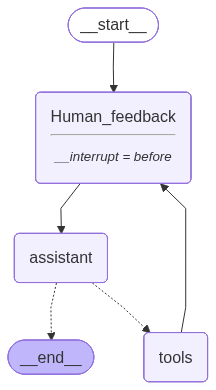

In [77]:
sys_msg=SystemMessage(content="You are a helpful AI assitance taked with performing arithmatic operations on a set of values")

def Human_feedback(state:MessagesState):
    pass

def assistant(state:MessagesState):
    return{"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

builder=StateGraph(MessagesState)

builder.add_node("Human_feedback",Human_feedback)
builder.add_node("tools",ToolNode(tools))
builder.add_node("assistant",assistant)

builder.add_edge(START,"Human_feedback")
builder.add_edge("Human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools","Human_feedback")
memory=MemorySaver()
graph=builder.compile(interrupt_before=["Human_feedback"],checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [80]:
initial_input={"message":"Multiply 7 and 8"}

thread={"configurable":{"thread_id":"8"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

user_input=input("Tell me hoe you wnat to update the state")
graph.update_state(thread,{"messages":user_input},as_node="Human_feedback")

for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

plaese multiply 6 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (ah3wm4wd4)
 Call ID: ah3wm4wd4
  Args:
    a: 6
    b: 7
================================= Tool Message =================================
Name: multiply

42
